In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from photutils.psf import IterativelySubtractedPSFPhotometry as ISPSF
from photutils.psf import extract_stars
from photutils.psf.groupstars import DAOGroup
from photutils import EPSFBuilder
from photutils.background import MMMBackground, MADStdBackgroundRMS
from photutils.utils import make_random_cmap
from matplotlib.colors import LogNorm

In [2]:
image_file = 'example_data/PAL5_3p6um.fits'
image_data = fits.getdata(image_file, ext=0)

hdu_list = fits.open(image_file)
hdr = hdu_list[0].header
exptime = hdr['EXPTIME']
fluxconv = hdr['FLUXCONV']
print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
hdu_list.close()

data = image_data * exptime / fluxconv

EXPTIME: 969.101928711
FLUXCONV: 0.1469


In [3]:
mean, median, std = sigma_clipped_stats(data, sigma=4.)
print(std)

90.65550994873047


### Source detection:

396


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


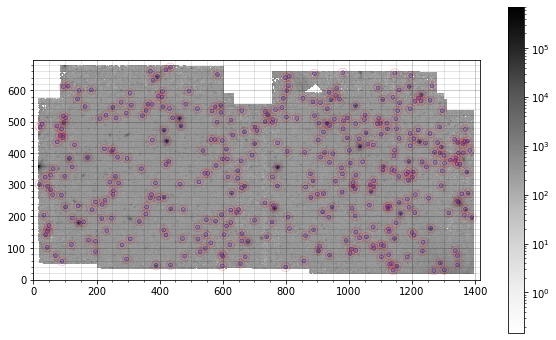

In [4]:
daofind = DAOStarFinder(threshold=20.*std, fwhm=5., roundlo = -0.5, roundhi = 0.5)
sources = daofind(data - median)

pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(pos, r=6.)
annuli = CircularAnnulus(pos, r_in=6., r_out=14.)
all_apers = [apertures, annuli]
norm = LogNorm()

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures.plot(color='blue', lw=.5, alpha=.75)
annuli.plot(color='red', lw=.4, alpha=.5)
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gcf().set_size_inches(10, 6)

#plt.savefig('images/temp_bigbig.png', dpi=500)

print(len(sources))

### Aperture photometry:

In [5]:
phot_table = aperture_photometry(data, all_apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1
       pix       pix                                 
--- --------- --------- -------------- --------------
  1 1269.3064 28.508046      92600.996            nan
  2 1140.1015  29.89543      68500.187            nan
  3 1302.3473 30.397221      157679.29            nan
  4 799.47313 39.357216            nan            nan
  5  1151.876 42.267178      218785.88      222474.25
  6 598.51676 42.895275       73387.81            nan
  7 388.36816 44.408524      509764.38            nan
  8 434.65172 45.887199      157735.74            nan
  9 1344.7805 46.493881      252053.69      344028.43
 10 1129.3896 48.632584      93489.895      215297.29
...       ...       ...            ...            ...
387 392.92187 643.20342      1583938.5      317183.44
388   810.826 644.57061       85214.77      202865.67
389 1195.9931 645.93454      78035.029      141176.73
390 583.32728 649.87594      254809.42      160596.73
391 890.30015  651.7475     

In [6]:
annulus_masks = annuli.to_mask(method='center')
aperture_correction = 1.125

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_annuli, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_annuli)
    
bkg_median = np.array(bkg_median)
phot_table['annulus_median'] = bkg_median
phot_table['aper_bkg'] = bkg_median * apertures.area
phot_table['aper_sum_bkgsub'] = aperture_correction * (phot_table['aperture_sum_0'] - phot_table['aper_bkg'])

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  ... annulus_median  aper_bkg aper_sum_bkgsub
       pix       pix    ...                                         
--- --------- --------- ... -------------- --------- ---------------
  1 1269.3064 28.508046 ...      639.80017 72359.695       22771.464
  2 1140.1015  29.89543 ...      408.88469 46243.769        25038.47
  3 1302.3473 30.397221 ...      896.03735 101339.44       63382.334
  4 799.47313 39.357216 ...      332.27927   37579.9             nan
  5  1151.876 42.267178 ...      424.39072 47997.459       192136.98
  6 598.51676 42.895275 ...      323.80988 36622.034       41361.498
  7 388.36816 44.408524 ...      453.93832 51339.215       515728.31
  8 434.65172 45.887199 ...      370.15779  41863.86       130355.86
  9 1344.7805 46.493881 ...      673.78427 76203.206       197831.79
 10 1129.3896 48.632584 ...      371.24455  41986.77       57941.016
...       ...       ... ...            ...       ...             ...
387 392.92187 643.20342 ...      5

### Building an ePSF:

In [7]:
cutout_size = 150    # this whole bit might not work properly, since the image doesn't go all the way to the edges of the graph
hsize = (cutout_size - 1) / 2
x = phot_table['xcenter'].value
y = phot_table['ycenter'].value
mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) &
        (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

star_table = Table()
star_table['x'] = x[mask]
star_table['y'] = y[mask]

print(star_table)

        x                  y        
------------------ -----------------
 938.7701653832884 77.37410441672336
1125.9279101663183 78.76224001363369
 596.7837183337431 79.37631842477109
1003.2755784179517 83.04754346081307
196.67964916710466 88.50805248984746
 527.9152464117656 87.70717157475129
 903.3400849517533 90.46650008368859
 1232.733731094852 90.20329309797657
1337.2090124333658 91.13601619983183
1021.6310893524874 92.19778347741581
               ...               ...
 802.6163501607926 598.3933910204953
 144.4628749320243 599.1253211916892
183.22995279587826 601.1421150607379
1159.1656209871937 600.8080122090334
 961.1459665455794 605.8646838467616
1092.4224930698877 607.3547162583446
 94.93378499319874 611.6285034355093
 1190.879497935457 612.1425828918634
109.61157230726558 612.9466601390858
 807.9913137327334 614.1704824976083
 1263.378765242715 614.1891990047048
Length = 327 rows


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


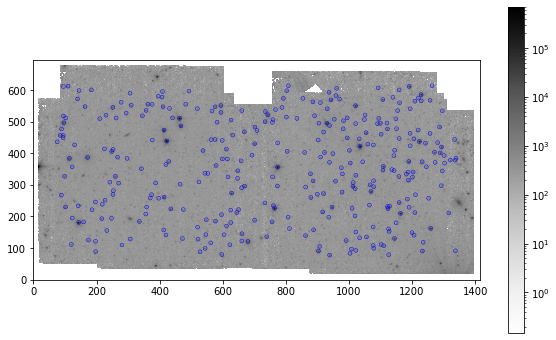

In [8]:
starpos = np.transpose((star_table['x'], star_table['y']))
starap = CircularAperture(starpos, r=6.)

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
starap.plot(color='blue', lw=.5)
plt.gcf().set_size_inches(10, 6)

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


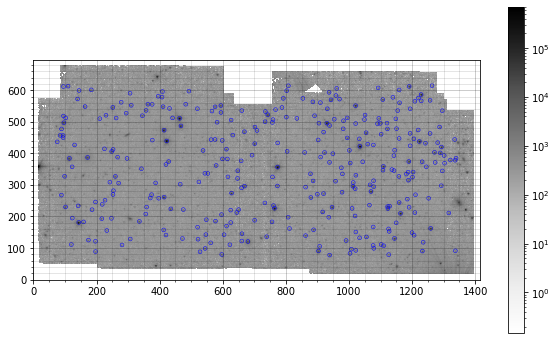

In [9]:
_, median_sub, _ = sigma_clipped_stats(data, sigma=4.) # could use 'median' as above if keeping same sigma
#data_sub = data - median_sub

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
starap.plot(color='blue', lw=.5, alpha=1.)
#annuli.plot(color='red', lw=.4, alpha=.5)
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gcf().set_size_inches(10, 6)

#plt.savefig('images/temp_subdata.png', dpi=500)

C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


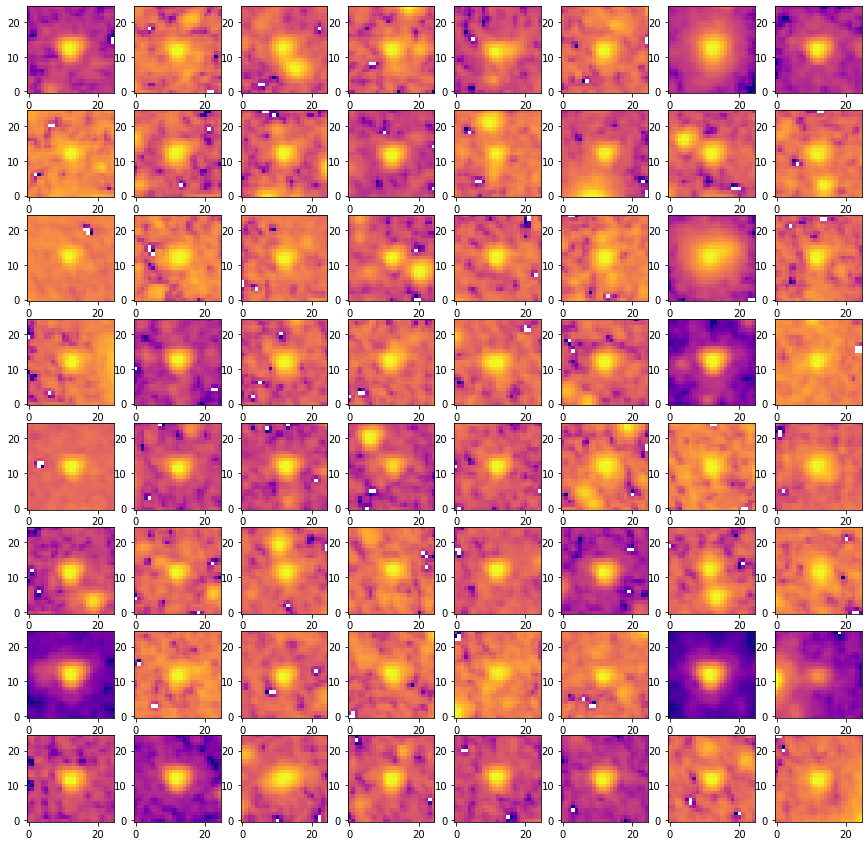

In [10]:
nddata = NDData(data = data)
stars = extract_stars(nddata, star_table, size=25)
nrows = 8
ncols = 8
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15), squeeze=True)
ax = ax.ravel()

for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='plasma')

Visualising the ePSF:

C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


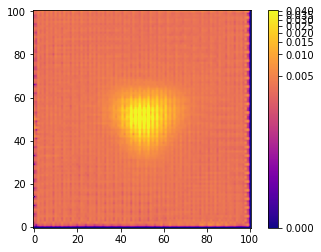

In [11]:
# maxiters = 3 looks good to me, oversampling could either be 3 or 4 (unless we want original resolution)
epsf_builder = EPSFBuilder(oversampling=4, maxiters=3, progress_bar=True)
epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='plasma')
#plt.imshow(epsf.data, norm=norm, origin='lower', cmap='plasma', vmin=0.01)
plt.colorbar()

### Beginning PSF photometry:

Re-doing source detection to find more stars:

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


1501


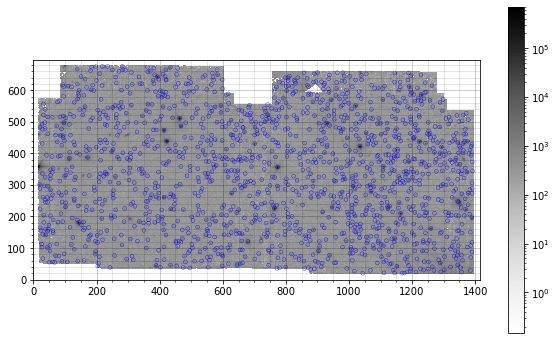

In [33]:
daofind_PSF = DAOStarFinder(threshold=4.*std, fwhm=5., roundlo = -0.5, roundhi = 0.5) # could use a sigma*gaussian_sigma_to_fwhm instead (see PSF tutorial)
sources_PSF = daofind_PSF(data - median)

pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
apertures_PSF = CircularAperture(pos_PSF, r=6.)
norm = LogNorm()

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures_PSF.plot(color='blue', lw=.5, alpha=.75)
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gcf().set_size_inches(10, 6)

plt.savefig('images/psf_01.png', dpi=500)
print(len(sources_PSF))

Grouping stars based on proximity to neighbours:

In [21]:
#sources_PSF['xcentroid'].name = 'x_0'
#sources_PSF['ycentroid'].name = 'y_0'

fwhm = 5.   # loosely determined using imexam with several stars
daogroup = DAOGroup(crit_separation = 2.5 * fwhm) # from tests, 2.5 - 3ish looks decent; groups stars roughly one aperture apart
star_groups = daogroup(sources_PSF)
star_groups = star_groups.group_by('group_id')
print(star_groups)

 id         x_0                y_0         ...          mag          group_id
---- ------------------ ------------------ ... --------------------- --------
   1 1043.5968327844782 19.917827469030705 ...  -0.27768393349502957        1
   2 1144.9178951806082  20.43013043923199 ...   -0.4451894807090285        2
  15 1140.1014964559472 29.895430300444655 ...   -2.1353023176135086        2
   3 1168.2738631692735 20.047196141850975 ...   -0.2008720474346853        3
   4 1175.5129513666666  20.39483560665527 ...  -0.04269590814002962        3
   9 1184.1851971585309  23.77006225867237 ...  -0.24517196041687114        3
  11 1194.1390364220574 27.080640277377018 ...   -0.3589415614945873        3
  19 1195.8439083467395  33.43824455051216 ...  -0.45327832561753156        3
   5  1111.083778699843  21.30059456176801 ...  -0.30673535315663975        4
   6 1212.4950592151688 23.557975820449176 ...  -0.23690991013664023        5
 ...                ...                ... ...                  

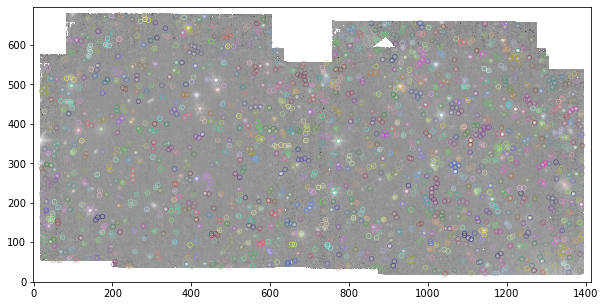

In [22]:
ncolors = max(star_groups['group_id'])
cmap = make_random_cmap(ncolors=ncolors, seed=1612)

plt.imshow(data, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys_r')
for i, group in enumerate(star_groups.groups):
    pos_group = np.transpose([group['x_0'], group['y_0']])
    ap_group = CircularAperture(pos_group, r=6.)
    ap_group.plot(color=cmap.colors[i], lw=.5)
    
plt.savefig('images/groups_test_03.png', dpi=500)
plt.gcf().set_size_inches(10, 6)
plt.show()

Replacing all NaNs with a float:

(697, 1415)


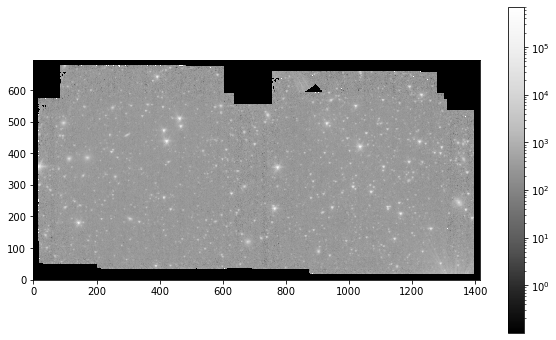

In [23]:
test = np.nan_to_num(data, nan=0.1)
print(test.shape)
plt.imshow(test, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys_r')
plt.colorbar()
plt.gcf().set_size_inches(10, 6)

***psf_model***: 'epsf' should already be in right format (EPSFModel class) for ISPSF, see very bottom of photutils' ePSF page

***aperture_radius***: need to specify, as FWHM probably can't be found from ePSF (could try as 6pix like central apertures, or the same as FWHM, 5pix)

In [24]:
bkg_estimation = MMMBackground()
fitter = LevMarLSQFitter()

PSF_photometry = ISPSF(finder = daofind_PSF,
                      group_maker = daogroup,
                      bkg_estimator = bkg_estimation,
                      psf_model = epsf,
                      fitter = fitter,
                      fitshape = 13,   # eg. 13 -> fits at pixels -6,-5,...,5,6 in x and y
                      niters = 1,
                      aperture_radius = 6.)  
result = PSF_photometry(image = test)
residual_image = PSF_photometry.get_residual_image()

#print(fit_info['message'])

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


In [26]:
#print(self.fit_info['message'])

Viewing the residual image:

### (maybe check that the image/data used isn't already bkg subtracted?)

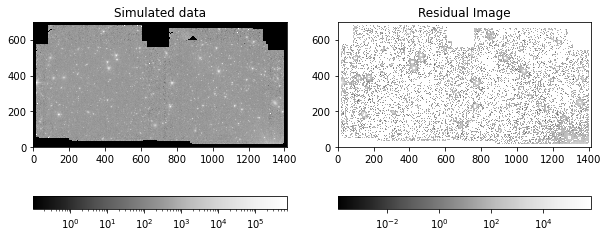

In [27]:
plt.subplot(1, 2, 1)
plt.imshow(test, cmap='Greys_r', interpolation='nearest', origin='lower', norm=LogNorm())
plt.title('Simulated data')
plt.colorbar(orientation='horizontal')

plt.subplot(1, 2, 2)
plt.imshow(residual_image, cmap='Greys_r', interpolation='nearest', origin='lower', norm=LogNorm())
plt.title('Residual Image')
plt.colorbar(orientation='horizontal')

plt.gcf().set_size_inches(10, 6)
#plt.show()

In [28]:
print(result['id', 'group_id', 'iter_detected', 'x_0', 'y_0'])
print(result['flux_0', 'x_fit', 'y_fit', 'flux_fit'])

 id  group_id iter_detected        x_0                y_0        
---- -------- ------------- ------------------ ------------------
   1        1             1  963.9859625411976  20.26193785583147
   2        2             1 1392.9748789200532 21.632071678551217
  11        2             1 1385.3450533368086  28.34676622140686
   3        3             1 1212.4950592151688  23.55797582044918
   4        4             1 1291.0273632436442 23.950220274507213
   5        5             1 1184.1851971585309  23.77006225867237
   8        5             1 1194.1390364220574 27.080640277377018
  16        5             1 1195.8439083467395  33.43824455051216
   6        6             1  876.1682969144416 26.764921338573068
  15        6             1   878.859445972865 32.154067116354874
 ...      ...           ...                ...                ...
1531     1012             1 457.16455159497525  669.0833909944839
1532     1013             1 381.70618532208124  670.1878711065783
1535     1

358


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


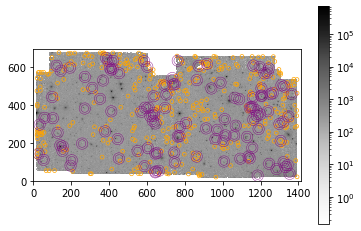

In [29]:
negatives = []
fail_x_0 = []
fail_y_0 = []
fail_x_fit = []
fail_y_fit = []

for i in range(len(result)):
    if result['flux_0'][i] < 0.:
        negatives.append(result['flux_0'][i])
        fail_x_0.append(result['x_0'][i])
        fail_y_0.append(result['y_0'][i])
    elif result['flux_fit'][i] < 0.:
        fail_x_fit.append(result['x_fit'][i])
        fail_y_fit.append(result['y_fit'][i])

#print(negatives)
print(len(negatives))

fails_0 = np.column_stack((fail_x_0, fail_y_0))
fails_fit = np.column_stack((fail_x_fit, fail_y_fit))
bad_apples_0 = CircularAperture(fails_0, r=10.)
bad_apples_fit = CircularAnnulus(fails_fit, r_in=20., r_out=30.)

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
bad_apples_0.plot(color='orange', lw=.7, alpha=1.)
bad_apples_fit.plot(color='purple', lw=.4, alpha=1.)

#plt.savefig('images/psf_fails_01.png', dpi=500)

In [31]:
flux_zeromag = 280.9         # from Reach et al 2005, section 5.4; for 3.6 band, = 280.9 +/- 4.1
zmag = 18.8                  # given in/calculated using IRAC handbook, section 4.8
aperture_correction = 1.125  # for 6, 6-14 pix apertures in channel 1; given in IRAC handbook, table 4.7
conv = fluxconv / exptime
negative_sums = []

result['apparent_mag'] = float('NaN')

for i in range(0, len(result)):
    if result['flux_0'][i] >= 0:
        result['apparent_mag'][i] = zmag - 2.5 * math.log10(aperture_correction * conv * result['flux_0'][i])
    else:
        negative_sums.append(result['id'][i])

for col in result.colnames:
    result[col].info.format = '%.8g'
print(result['id', 'x_0', 'y_0', 'flux_0', 'apparent_mag'])
#print(negative_sums)

print(np.count_nonzero(~np.isnan(result['apparent_mag'])))

 id     x_0       y_0      flux_0   apparent_mag
---- --------- --------- ---------- ------------
   1 963.98596 20.261938 -6979.8476          nan
   2 1392.9749 21.632072 -1952.8252          nan
  11 1385.3451 28.346766   40525.65    16.701163
   3 1212.4951 23.557976  17205.699    17.631307
   4 1291.0274  23.95022  69604.949    16.113888
   5 1184.1852 23.770062  1568.3751    20.231863
   8  1194.139  27.08064  2015.5417    19.959508
  16 1195.8439 33.438245  14667.298    17.804613
   6  876.1683 26.764921 -14667.066          nan
  15 878.85945 32.154067 -6144.8506          nan
 ...       ...       ...        ...          ...
1531 457.16455 669.08339 -10909.474          nan
1532 381.70619 670.18787 -8923.2248          nan
1535  361.3496 672.76407 -8337.9363          nan
1540 367.13374 676.26962 -15231.659          nan
1541 372.01899 676.89289 -13863.493          nan
1544 352.97792 677.72301 -18370.138          nan
1533 433.76179 672.58093  107962.72    15.637303
1536 197.31713 674.7

In [ ]:
#plt.hist(result['apparent_mag'], bins=200)

In [32]:
result['id', 'x_0', 'y_0', 'apparent_mag'].write('outputs/psf_test01.txt', format='csv', overwrite=True)